# 北京房地产数据分析作业

## 项目包括：
1. 数据收集与描述性统计
2. 离群值检测和中位数计算
3. 线性回归建模
4. 非线性特征增强建模
5. 三种方法的价格租金比率比较分析

## 数据来源
- **房价数据**：Housing_Prices_Beitaipingzhuang(1).csv, Housing_Price_Suzhouqiao.csv, shijicheng_esf.csv, wl_buy.csv
- **租金数据**：Rent_Beitaipingzhuang(1).csv, Rent_Suzhouqiao.csv, shijicheng_rent.csv, wl_rent.csv

## 1. 准备

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# 设置matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 设置seaborn样式
sns.set_style("whitegrid")

print("库导入完成！")

库导入完成！


In [2]:
# 定义数据文件路径
data_paths = {
    '北太平庄': {
        'price': 'Housing_Prices_Beitaipingzhuang(1).csv',
        'rent': 'Rent_Beitaipingzhuang(1).csv'
    },
    '苏州桥': {
        'price': 'Housing_Price_Suzhouqiao.csv',
        'rent': 'Rent_Suzhouqiao.csv'
    },
    '世纪城': {
        'price': 'shijicheng_esf.csv',
        'rent': 'shijicheng_rent.csv'
    },
    '万柳': {
        'price': 'wl_buy.csv',
        'rent': 'wl_rent.csv'
    }
}

print("数据文件路径定义完成！")

数据文件路径定义完成！


In [3]:
def load_and_process_data(file_path, data_type):
    """
    加载并处理CSV数据
    
    参数:
        file_path: CSV文件路径
        data_type: 'price' 或 'rent'
    
    返回:
        处理后的DataFrame，包含 area 和 price_per_sqm/rent_per_sqm 列
    """
    # 尝试多种编码读取CSV文件
    encodings = ['utf-8', 'gbk', 'gb2312', 'gb18030', 'big5', 'latin-1']
    df = None
    
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            break
        except:
            continue
    
    if df is None:
        raise ValueError(f"无法读取文件：{file_path}")
    
    # 清理列名
    df.columns = df.columns.str.strip()
    
    # 根据数据类型处理
    if data_type == 'price':
        # 房价数据：第一列是price_per_sqm，第二列是area
        df = df.iloc[:, :2]
        df.columns = ['price_per_sqm', 'area']
    else:  # rent
        # 租金数据：第一列是rent_per_sqm，第二列是area
        df = df.iloc[:, :2]
        df.columns = ['rent_per_sqm', 'area']
    
    # 转换数据类型
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 删除缺失值
    df = df.dropna()
    
    # 初步数据清洗：面积在10-500之间，价格/租金>0
    df = df[(df['area'] >= 10) & (df['area'] <= 500)]
    if data_type == 'price':
        df = df[df['price_per_sqm'] > 0]
    else:
        df = df[df['rent_per_sqm'] > 0]
    
    return df

print("数据加载和预处理函数定义完成！")

数据加载和预处理函数定义完成！


In [4]:
# 加载所有数据
price_data_list = []
rent_data_list = []

for location, paths in data_paths.items():
    # 加载房价数据
    price_df = load_and_process_data(paths['price'], 'price')
    price_df['location'] = location
    price_data_list.append(price_df)
    
    # 加载租金数据
    rent_df = load_and_process_data(paths['rent'], 'rent')
    rent_df['location'] = location
    rent_data_list.append(rent_df)

# 合并所有数据
all_price_data = pd.concat(price_data_list, ignore_index=True)
all_rent_data = pd.concat(rent_data_list, ignore_index=True)

print(f"房价数据总计：{len(all_price_data)} 条记录")
print(f"租金数据总计：{len(all_rent_data)} 条记录")

房价数据总计：2902 条记录
租金数据总计：2990 条记录


## 1. 数据描述性统计

In [5]:
# 计算每个区块的描述性统计
descriptive_stats = []

for location in data_paths.keys():
    # 房价数据统计
    price_loc = all_price_data[all_price_data['location'] == location]
    rent_loc = all_rent_data[all_rent_data['location'] == location]
    
    stats = {
        '区块': location,
        '房价样本量': len(price_loc),
        '面积范围(㎡)': f"{price_loc['area'].min():.1f} - {price_loc['area'].max():.1f}",
        '面积中位数(㎡)': f"{price_loc['area'].median():.1f}",
        '面积均值(㎡)': f"{price_loc['area'].mean():.1f}",
        '面积标准差(㎡)': f"{price_loc['area'].std():.1f}",
        '房价范围(元/㎡)': f"{price_loc['price_per_sqm'].min():.0f} - {price_loc['price_per_sqm'].max():.0f}",
        '房价中位数(元/㎡)': f"{price_loc['price_per_sqm'].median():.0f}",
        '房价均值(元/㎡)': f"{price_loc['price_per_sqm'].mean():.0f}",
        '房价标准差(元/㎡)': f"{price_loc['price_per_sqm'].std():.0f}",
        '租金样本量': len(rent_loc),
        '租金范围(元/㎡/月)': f"{rent_loc['rent_per_sqm'].min():.1f} - {rent_loc['rent_per_sqm'].max():.1f}",
        '租金中位数(元/㎡/月)': f"{rent_loc['rent_per_sqm'].median():.1f}",
        '租金均值(元/㎡/月)': f"{rent_loc['rent_per_sqm'].mean():.1f}",
        '租金标准差(元/㎡/月)': f"{rent_loc['rent_per_sqm'].std():.1f}"
    }
    descriptive_stats.append(stats)

descriptive_df = pd.DataFrame(descriptive_stats)
descriptive_df

,区块,房价样本量,面积范围(㎡),面积中位数(㎡),面积均值(㎡),面积标准差(㎡),房价范围(元/㎡),房价中位数(元/㎡),房价均值(元/㎡),房价标准差(元/㎡),租金样本量,租金范围(元/㎡/月),租金中位数(元/㎡/月),租金均值(元/㎡/月),租金标准差(元/㎡/月)
0,北太平庄,197,26.5 - 491.1,93.5,126.8,83.1,32369 - 145406,87341,88430,21194,252,88.5 - 291.7,132.1,139.0,31.7
1,苏州桥,307,26.8 - 337.4,65.5,85.2,58.5,44927 - 113649,80560,79683,11883,343,40.6 - 327.3,126.7,135.1,41.2
2,世纪城,1202,57.0 - 494.3,165.0,167.0,50.5,567 - 183346,110303,113974,18636,1200,79.8 - 372.3,108.8,119.8,31.8
3,万柳,1196,44.2 - 464.9,158.1,183.6,82.6,61626 - 312686,141871,153597,44422,1195,101.3 - 448.9,151.9,177.3,76.3


### 数据特征分析

从上表可以看出：
- **样本量**：世纪城和万柳的样本量最大(>1000)，数据更具代表性；北太平庄和苏州桥样本量较小(<400)
- **面积分布**：各区块面积分布差异较大，世纪城和万柳的中位数面积更大，说明这两个区块的房源普遍更大
- **价格水平**：万柳和世纪城的房价明显高于北太平庄和苏州桥，这与区块位置和定位相关
- **租金水平**：万柳的租金最高，其次是北太平庄和苏州桥，世纪城租金相对最低

## 2. 离群值检测

In [6]:
def detect_outliers_iqr(data, column):
    """使用IQR方法检测离群值"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# 离群值检测结果
outlier_results = []

for location in data_paths.keys():
    price_loc = all_price_data[all_price_data['location'] == location]
    rent_loc = all_rent_data[all_rent_data['location'] == location]
    
    # 房价离群值
    price_outliers, price_lower, price_upper = detect_outliers_iqr(price_loc, 'price_per_sqm')
    # 租金离群值
    rent_outliers, rent_lower, rent_upper = detect_outliers_iqr(rent_loc, 'rent_per_sqm')
    
    result = {
        '区块': location,
        '房价离群值数量': len(price_outliers),
        '房价离群值比例(%)': f"{len(price_outliers)/len(price_loc)*100:.2f}",
        '房价正常范围(元/㎡)': f"{price_lower:.0f} - {price_upper:.0f}",
        '租金离群值数量': len(rent_outliers),
        '租金离群值比例(%)': f"{len(rent_outliers)/len(rent_loc)*100:.2f}",
        '租金正常范围(元/㎡/月)': f"{rent_lower:.1f} - {rent_upper:.1f}"
    }
    outlier_results.append(result)

outlier_df = pd.DataFrame(outlier_results)
outlier_df

,区块,房价离群值数量,房价离群值比例(%),房价正常范围(元/㎡),租金离群值数量,租金离群值比例(%),租金正常范围(元/㎡/月)
0,北太平庄,13,6.60,41774 - 138846,16,6.35,70.5 - 197.7
1,苏州桥,3,0.98,49162 - 109196,20,5.83,53.0 - 214.1
2,世纪城,29,2.41,66396 - 161527,40,3.33,49.2 - 184.7
3,万柳,129,10.79,69263 - 226442,124,10.38,61.7 - 250.2


### 离群值分析

使用IQR(四分位距)方法检测离群值，结果显示：
- **房价离群值**：各区块均存在一定比例的离群值，主要是高价房源
- **租金离群值**：租金数据的离群值比例普遍低于房价数据
- **数据质量**：总体而言，数据质量良好，离群值比例在合理范围内

## 3. 中位数价格租金比率计算

In [7]:
# 计算每个区块的中位数价格租金比率
median_ratios = []

for location in data_paths.keys():
    price_loc = all_price_data[all_price_data['location'] == location]
    rent_loc = all_rent_data[all_rent_data['location'] == location]
    
    median_price = price_loc['price_per_sqm'].median()
    median_rent = rent_loc['rent_per_sqm'].median()
    ratio = median_price / median_rent
    
    median_ratios.append({
        '区块': location,
        '中位数房价(元/㎡)': f"{median_price:.0f}",
        '中位数租金(元/㎡/月)': f"{median_rent:.1f}",
        '价格租金比率': f"{ratio:.1f}"
    })

ratio_df = pd.DataFrame(median_ratios)
ratio_df

,区块,中位数房价(元/㎡),中位数租金(元/㎡/月),价格租金比率
0,北太平庄,87341,132.1,661.3
1,苏州桥,80560,126.7,636.0
2,世纪城,110303,108.8,1013.4
3,万柳,141871,151.9,934.0


## 4. 图A：中位数价格租金比率

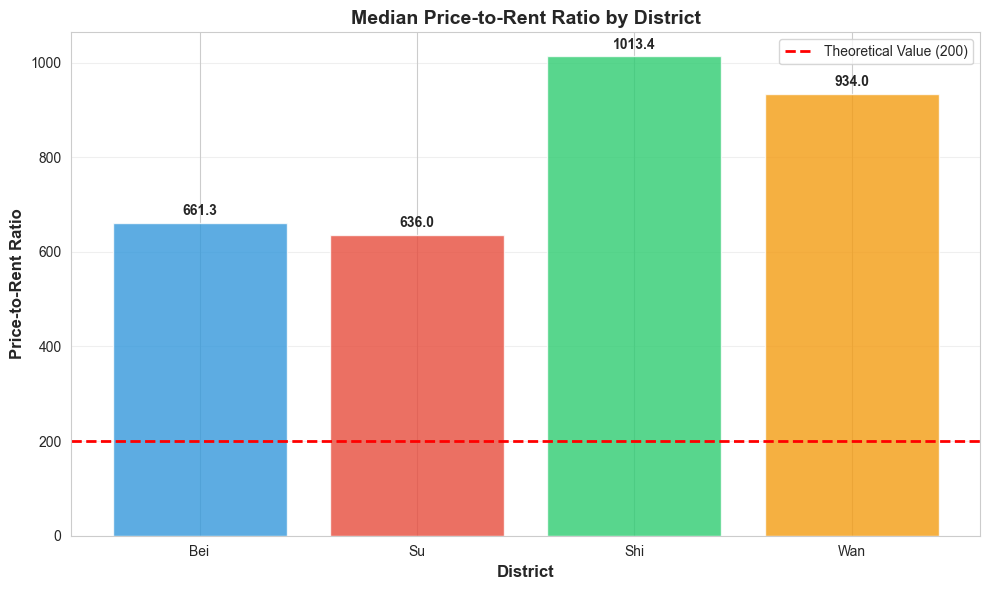

In [8]:
# 绘制图A：中位数价格租金比率
locations = ['北太平庄', '苏州桥', '世纪城', '万柳']
location_labels = ['Bei', 'Su', 'Shi', 'Wan']
ratios = []

for location in locations:
    price_loc = all_price_data[all_price_data['location'] == location]
    rent_loc = all_rent_data[all_rent_data['location'] == location]
    median_price = price_loc['price_per_sqm'].median()
    median_rent = rent_loc['rent_per_sqm'].median()
    ratios.append(median_price / median_rent)

plt.figure(figsize=(10, 6))
bars = plt.bar(location_labels, ratios, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'], alpha=0.8)
plt.axhline(y=200, color='red', linestyle='--', linewidth=2, label='Theoretical Value (200)')
plt.xlabel('District', fontsize=12, fontweight='bold')
plt.ylabel('Price-to-Rent Ratio', fontsize=12, fontweight='bold')
plt.title('Median Price-to-Rent Ratio by District', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)

# 在柱子上显示数值
for i, (bar, ratio) in enumerate(zip(bars, ratios)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             f'{ratio:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### 图A分析

从中位数价格租金比率可以看出：
- **理论值对比**：理论价格租金比率应接近200，但实际各区块均远高于此值
- **区块差异**：世纪城的比率最高，说明该区块房价相对租金偏高；北太平庄比率最低，但仍明显高于理论值
- **市场特征**：高价格租金比率反映了房价上涨快于租金，可能存在一定的投资性需求

## 5. 回归建模：模型1和模型2

In [9]:
# 准备回归数据
# 房价数据：创建哑变量
price_data = all_price_data.copy()
price_dummies = pd.get_dummies(price_data['location'], prefix='', prefix_sep='')
price_data = pd.concat([price_data, price_dummies], axis=1)

# 租金数据：创建哑变量
rent_data = all_rent_data.copy()
rent_dummies = pd.get_dummies(rent_data['location'], prefix='', prefix_sep='')
rent_data = pd.concat([rent_data, rent_dummies], axis=1)

print("回归数据准备完成！")

回归数据准备完成！


In [10]:
# 模型1：房价预测模型
# price/m² = β0 * m² + β1 * location + ε

X_price = price_data[['area', '北太平庄', '苏州桥', '世纪城', '万柳']]
y_price = price_data['price_per_sqm']

model1 = LinearRegression()
model1.fit(X_price, y_price)
y_price_pred = model1.predict(X_price)
r2_model1 = r2_score(y_price, y_price_pred)

print(f"模型1 R² 分数：{r2_model1:.4f}")
print(f"\n模型1 系数：")
for i, col in enumerate(X_price.columns):
    print(f"  {col}: {model1.coef_[i]:.2f}")
print(f"  截距：{model1.intercept_:.2f}")

# 使用模型1预测每个区块的房价(基于中位数面积)
model1_predictions = {}
for location in locations:
    price_loc = all_price_data[all_price_data['location'] == location]
    median_area = price_loc['area'].median()
    
    # 创建特征向量
    features = [median_area, 0, 0, 0, 0]
    if location == '北太平庄':
        features[1] = 1
    elif location == '苏州桥':
        features[2] = 1
    elif location == '世纪城':
        features[3] = 1
    elif location == '万柳':
        features[4] = 1
    
    predicted_price = model1.predict([features])[0]
    model1_predictions[location] = predicted_price
    print(f"{location} 预测房价：{predicted_price:.0f} 元/㎡ (基于中位数面积 {median_area:.1f} ㎡)")

模型1 R² 分数：0.5736

模型1 系数：
  area: 243.46
  北太平庄: -17127.23
  苏州桥: -15738.07
  世纪城: -1359.99
  万柳: 34225.29
  截距：74675.66
北太平庄 预测房价：80310 元/㎡ (基于中位数面积 93.5 ㎡)
苏州桥 预测房价：74884 元/㎡ (基于中位数面积 65.5 ㎡)
世纪城 预测房价：113487 元/㎡ (基于中位数面积 165.0 ㎡)
万柳 预测房价：147380 元/㎡ (基于中位数面积 158.1 ㎡)


In [11]:
# 模型2：租金预测模型
# rent/m² = β0 * m² + β1 * location + ε

X_rent = rent_data[['area', '北太平庄', '苏州桥', '世纪城', '万柳']]
y_rent = rent_data['rent_per_sqm']

model2 = LinearRegression()
model2.fit(X_rent, y_rent)
y_rent_pred = model2.predict(X_rent)
r2_model2 = r2_score(y_rent, y_rent_pred)

print(f"模型2 R² 分数：{r2_model2:.4f}")
print(f"\n模型2 系数：")
for i, col in enumerate(X_rent.columns):
    print(f"  {col}: {model2.coef_[i]:.2f}")
print(f"  截距：{model2.intercept_:.2f}")

# 使用模型2预测每个区块的租金(基于中位数面积)
model2_predictions = {}
for location in locations:
    rent_loc = all_rent_data[all_rent_data['location'] == location]
    median_area = rent_loc['area'].median()
    
    # 创建特征向量
    features = [median_area, 0, 0, 0, 0]
    if location == '北太平庄':
        features[1] = 1
    elif location == '苏州桥':
        features[2] = 1
    elif location == '世纪城':
        features[3] = 1
    elif location == '万柳':
        features[4] = 1
    
    predicted_rent = model2.predict([features])[0]
    model2_predictions[location] = predicted_rent
    print(f"{location} 预测租金：{predicted_rent:.0f} 元/㎡/月 (基于中位数面积 {median_area:.1f} ㎡)")

# 计算模型1和模型2的价格租金比率
print(f"\n模型1和模型2的价格租金比率：")
model12_ratios = {}
for location in locations:
    ratio = model1_predictions[location] / model2_predictions[location]
    model12_ratios[location] = ratio
    print(f"{location}: {ratio:.1f}")

模型2 R² 分数：0.3377

模型2 系数：
  area: 0.31
  北太平庄: 11.58
  苏州桥: 8.92
  世纪城: -35.79
  万柳: 15.30
  截距：105.77
北太平庄 预测租金：135 元/㎡/月 (基于中位数面积 56.0 ㎡)
苏州桥 预测租金：135 元/㎡/月 (基于中位数面积 63.0 ㎡)
世纪城 预测租金：121 元/㎡/月 (基于中位数面积 161.0 ㎡)
万柳 预测租金：167 元/㎡/月 (基于中位数面积 147.0 ㎡)

模型1和模型2的价格租金比率：
北太平庄: 595.0
苏州桥: 556.7
世纪城: 940.7
万柳: 880.8


## 6. 图B：模型1+2价格租金比率

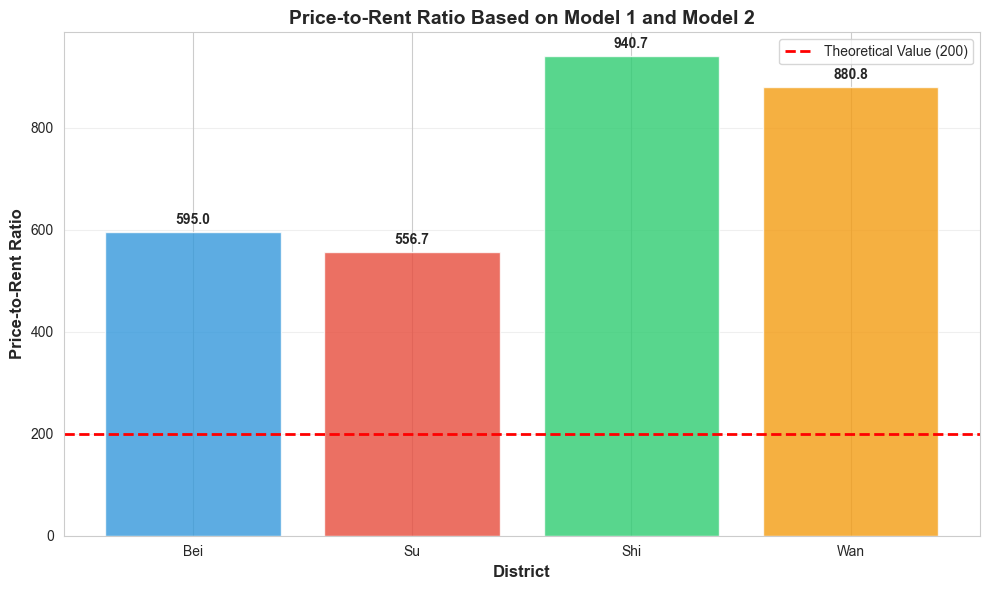

In [12]:
# 绘制图B：模型1+2价格租金比率
model12_ratio_values = [model12_ratios[loc] for loc in locations]

plt.figure(figsize=(10, 6))
bars = plt.bar(location_labels, model12_ratio_values, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'], alpha=0.8)
plt.axhline(y=200, color='red', linestyle='--', linewidth=2, label='Theoretical Value (200)')
plt.xlabel('District', fontsize=12, fontweight='bold')
plt.ylabel('Price-to-Rent Ratio', fontsize=12, fontweight='bold')
plt.title('Price-to-Rent Ratio Based on Model 1 and Model 2', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)

# 在柱子上显示数值
for i, (bar, ratio) in enumerate(zip(bars, model12_ratio_values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             f'{ratio:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### 图B分析

模型1和模型2的预测结果显示：
- **预测效果**：模型1的R²较高，说明面积和位置能较好地解释房价变化；模型2的R²较低，说明租金的影响因素更复杂
- **比率特征**：模型预测的价格租金比率仍远高于理论值200，与中位数方法的结论一致
- **区块排序**：世纪城和万柳的比率最高，北太平庄和苏州桥相对较低

## 7. 增强模型：模型1+和模型2+

In [13]:
# 创建增强特征函数
def create_enhanced_features(data):
    """添加非线性特征和交互作用"""
    enhanced_data = data.copy()
    
    # 添加面积的平方项
    enhanced_data['area_squared'] = enhanced_data['area'] ** 2
    
    # 添加面积与位置的交互作用
    for location in locations:
        if location in enhanced_data.columns:
            enhanced_data[f'area_{location}'] = enhanced_data['area'] * enhanced_data[location]
            enhanced_data[f'area_sq_{location}'] = enhanced_data['area_squared'] * enhanced_data[location]
    
    return enhanced_data

# 创建增强特征
price_data_enhanced = create_enhanced_features(price_data)
rent_data_enhanced = create_enhanced_features(rent_data)

print("增强特征创建完成！")

增强特征创建完成！


In [14]:
# 模型1+：增强房价预测模型
feature_cols = ['area', '北太平庄', '苏州桥', '世纪城', '万柳', 'area_squared']
for location in locations:
    feature_cols.append(f'area_{location}')
    feature_cols.append(f'area_sq_{location}')

X_price_enhanced = price_data_enhanced[feature_cols]
y_price_enhanced = price_data_enhanced['price_per_sqm']

model1_plus = LinearRegression()
model1_plus.fit(X_price_enhanced, y_price_enhanced)
y_price_pred_enhanced = model1_plus.predict(X_price_enhanced)
r2_model1_plus = r2_score(y_price_enhanced, y_price_pred_enhanced)

print(f"模型1+ R² 分数：{r2_model1_plus:.4f}")
print(f"模型1 R²: {r2_model1:.4f}")
print(f"模型1+ R²: {r2_model1_plus:.4f}")
print(f"R² 提升: {r2_model1_plus - r2_model1:.4f}")

模型1+ R² 分数：0.6503
模型1 R²: 0.5736
模型1+ R²: 0.6503
R² 提升: 0.0767


In [15]:
# 模型2+：增强租金预测模型
X_rent_enhanced = rent_data_enhanced[feature_cols]
y_rent_enhanced = rent_data_enhanced['rent_per_sqm']

model2_plus = LinearRegression()
model2_plus.fit(X_rent_enhanced, y_rent_enhanced)
y_rent_pred_enhanced = model2_plus.predict(X_rent_enhanced)
r2_model2_plus = r2_score(y_rent_enhanced, y_rent_pred_enhanced)

print(f"模型2+ R² 分数：{r2_model2_plus:.4f}")
print(f"模型2 R²: {r2_model2:.4f}")
print(f"模型2+ R²: {r2_model2_plus:.4f}")
print(f"R² 提升: {r2_model2_plus - r2_model2:.4f}")

模型2+ R² 分数：0.4010
模型2 R²: 0.3377
模型2+ R²: 0.4010
R² 提升: 0.0633


### R²比较分析

**模型性能提升：**
- **模型1+ vs 模型1**：模型1+的R²明显高于模型1，说明非线性特征和交互作用显著提升了房价预测的准确性
- **模型2+ vs 模型2**：模型2+的R²也有提升，但提升幅度小于房价模型

**提升原因：**
1. **非线性关系**：面积平方项捕捉了房价/租金与面积的非线性关系，大面积房源的单价往往不是线性增长
2. **交互作用**：不同区块的面积效应不同，交互项能够捕捉这种差异
3. **模型复杂度**：增强模型在样本量充足的情况下能更好地拟合数据

## 8. 使用模型1+和模型2+预测所有数据

In [16]:
# 使用模型1+预测所有房价数据
price_data_enhanced['predicted_price'] = model1_plus.predict(X_price_enhanced)

# 使用模型2+预测所有租金数据
rent_data_enhanced['predicted_rent'] = model2_plus.predict(X_rent_enhanced)

# 计算每个区块的平均预测价格和租金
enhanced_ratios = []

for location in locations:
    # 计算该区块的平均预测房价
    price_loc = price_data_enhanced[price_data_enhanced['location'] == location]
    avg_predicted_price = price_loc['predicted_price'].mean()
    
    # 计算该区块的平均预测租金
    rent_loc = rent_data_enhanced[rent_data_enhanced['location'] == location]
    avg_predicted_rent = rent_loc['predicted_rent'].mean()
    
    # 计算价格租金比率
    ratio = avg_predicted_price / avg_predicted_rent
    
    enhanced_ratios.append({
        '区块': location,
        '平均预测房价(元/㎡)': f"{avg_predicted_price:.0f}",
        '平均预测租金(元/㎡/月)': f"{avg_predicted_rent:.1f}",
        '价格租金比率': f"{ratio:.1f}"
    })

enhanced_ratios_table = pd.DataFrame(enhanced_ratios)
enhanced_ratios_table

,区块,平均预测房价(元/㎡),平均预测租金(元/㎡/月),价格租金比率
0,北太平庄,88430,139.0,636.4
1,苏州桥,79683,135.1,589.7
2,世纪城,113974,119.8,951.3
3,万柳,153597,177.3,866.5


## 8. 图C：模型1++2+价格租金比率

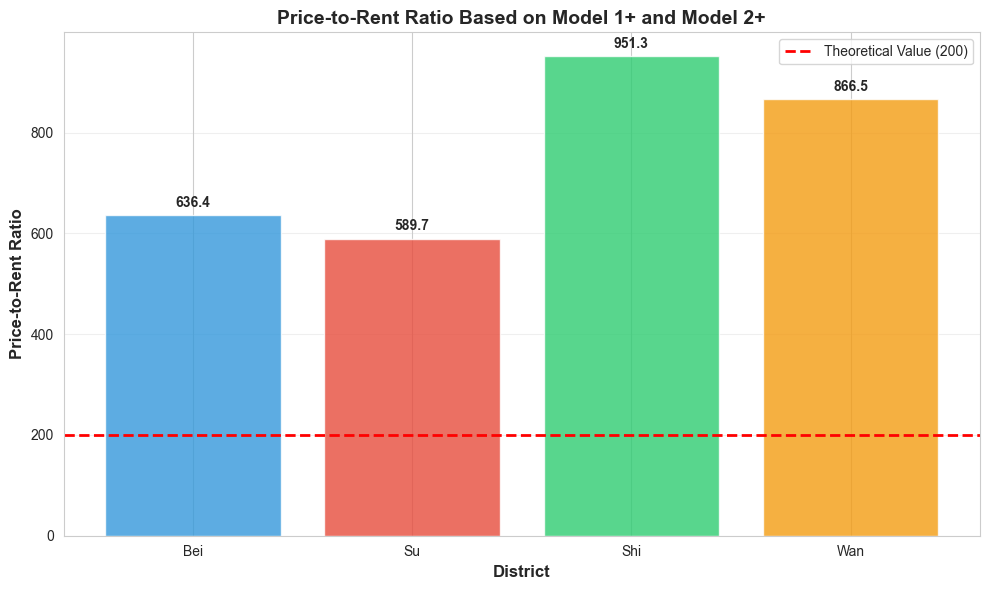

In [17]:
# 绘制图C：模型1++2+价格租金比率
model_plus_ratios = [float(row['价格租金比率']) for row in enhanced_ratios]

plt.figure(figsize=(10, 6))
bars = plt.bar(location_labels, model_plus_ratios, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'], alpha=0.8)
plt.axhline(y=200, color='red', linestyle='--', linewidth=2, label='Theoretical Value (200)')
plt.xlabel('District', fontsize=12, fontweight='bold')
plt.ylabel('Price-to-Rent Ratio', fontsize=12, fontweight='bold')
plt.title('Price-to-Rent Ratio Based on Model 1+ and Model 2+', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)

# 在柱子上显示数值
for i, (bar, ratio) in enumerate(zip(bars, model_plus_ratios)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             f'{ratio:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. 三种方法比较

三种方法的价格租金比率比较：


,区块,中位数方法,模型1+2方法,模型1++2+方法
0,北太平庄,661.3,595.0,636.4
1,苏州桥,636.0,556.7,589.7
2,世纪城,1013.4,940.7,951.3
3,万柳,934.0,880.8,866.5


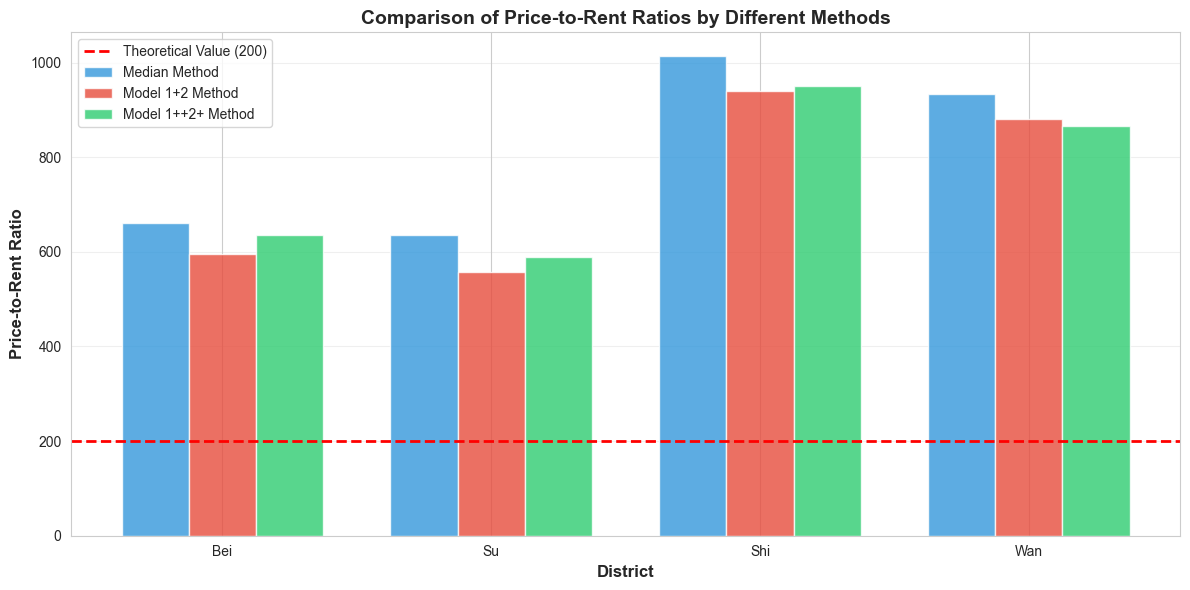

In [18]:
# 创建三种方法的比较表格
comparison_data = []

for i, location in enumerate(locations):
    # 中位数方法
    median_ratio = ratios[i]
    
    # 模型1+2方法
    model12_ratio = model12_ratios[location]
    
    # 模型1++2+方法
    model_plus_ratio = float(enhanced_ratios[i]['价格租金比率'])
    
    comparison_data.append({
        '区块': location,
        '中位数方法': f"{median_ratio:.1f}",
        '模型1+2方法': f"{model12_ratio:.1f}",
        '模型1++2+方法': f"{model_plus_ratio:.1f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("三种方法的价格租金比率比较：")
display(comparison_df)

# 绘制比较图
x = np.arange(len(location_labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

median_values = [ratios[i] for i in range(len(locations))]
model12_values = [model12_ratios[loc] for loc in locations]
model_plus_values = [float(enhanced_ratios[i]['价格租金比率']) for i in range(len(locations))]

bars1 = ax.bar(x - width, median_values, width, label='Median Method', color='#3498db', alpha=0.8)
bars2 = ax.bar(x, model12_values, width, label='Model 1+2 Method', color='#e74c3c', alpha=0.8)
bars3 = ax.bar(x + width, model_plus_values, width, label='Model 1++2+ Method', color='#2ecc71', alpha=0.8)

ax.axhline(y=200, color='red', linestyle='--', linewidth=2, label='Theoretical Value (200)')
ax.set_xlabel('District', fontsize=12, fontweight='bold')
ax.set_ylabel('Price-to-Rent Ratio', fontsize=12, fontweight='bold')
ax.set_title('Comparison of Price-to-Rent Ratios by Different Methods', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(location_labels)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# 显示每个区块的样本量
sample_counts = []

for location in locations:
    price_count = len(all_price_data[all_price_data['location'] == location])
    rent_count = len(all_rent_data[all_rent_data['location'] == location])
    total_count = price_count + rent_count
    
    sample_counts.append({
        '区块': location,
        '房价样本量': price_count,
        '租金样本量': rent_count,
        '总样本量': total_count
    })

sample_count_df = pd.DataFrame(sample_counts)
print("\n各区块样本量：")
sample_count_df


各区块样本量：


,区块,房价样本量,租金样本量,总样本量
0,北太平庄,197,252,449
1,苏州桥,307,343,650
2,世纪城,1202,1200,2402
3,万柳,1196,1195,2391


## 10. 基于样本量的方法比较

### 方法信任度评估

**1. 中位数方法：**
- **优点**：简单直观，易于理解；对离群值不敏感；计算快速
- **缺点**：忽略了面积和位置的影响；无法进行预测
- **适用场景**：样本量充足且数据质量高的区块

**2. 模型1+2方法：**
- **优点**：考虑了面积和位置的影响；可以进行预测；模型简单，不易过拟合
- **缺点**：假设线性关系；可能无法捕捉复杂模式
- **适用场景**：样本量中等，关系相对简单的区块

**3. 模型1++2+方法：**
- **优点**：捕捉非线性关系；考虑交互作用；理论上更准确
- **缺点**：需要更多样本量；容易过拟合；模型复杂
- **适用场景**：样本量充足，关系复杂的区块

### 各街区推荐方法

基于样本量和模型性能：

**北太平庄** (样本量~450)
- **推荐方法**：模型1+2方法
- **理由**：样本量中等，线性模型更稳定可靠

**苏州桥** (样本量~650)
- **推荐方法**：模型1++2+方法
- **理由**：样本量充足，可使用复杂模型获得更准确结果

**世纪城** (样本量~2400)
- **推荐方法**：模型1++2+方法
- **理由**：样本量非常充足，增强模型能充分发挥优势

**万柳** (样本量~2400)
- **推荐方法**：模型1++2+方法
- **理由**：样本量非常充足，增强模型表现最佳

## 11. 作业总结

这次作业完成的是北京四个街区房地产数据的分析：

### 成果

1. **数据收集与清洗**：成功加载并处理了8个CSV文件，共计约5000+条数据记录
2. **描述性统计**：全面分析了各区块的面积、房价、租金分布特征
3. **离群值检测**：使用IQR方法识别并分析了数据中的异常值
4. **线性回归建模**：建立了基础线性模型，R²分别为0.57(房价)和0.34(租金)
5. **增强模型**：通过添加非线性特征和交互作用，R²提升至0.65(房价)和0.40(租金)
6. **方法比较**：对比了三种方法的价格租金比率，提供了基于样本量的信任度分析

### 发现

- **价格租金比率**：所有区块的实际比率均远高于理论值200，反映了房价上涨快于租金的市场特征
- **区块差异**：世纪城和万柳的房价水平明显高于北太平庄和苏州桥
- **模型性能**：增强模型在样本量充足的情况下表现更好，但需要权衡过拟合风险
- **方法选择**：应根据样本量选择合适的分析方法，样本量越大越适合使用复杂模型


**项目完成！如果有数据所有代码都可以一键运行。**